# Assignment 2 - Convolutional Neural Network (CNN)

Submission DDL: 10.11.2023 23:59.

* For the tasks that require the text answer use *Insert* > *Text cell* and provide your answer in this cell. Text cell supports Markdown.
* Submit your work to the submission box on MyCourses. You should submit only the **.ipynb file** with your code.
* Before submission use *Runtime* > *Run all* to make sure that your notebook runs without errors.
* To download the file from Google Colab use *File* > *Download* > *Download .ipynb*.
* Submit the file with the name: A2_NAME_SURNAME_STUDENT NUMBER.ipynb

**NB! Before editing the file, save a local copy to your Google Drive, otherwise your progress will be lost**

In this assignment, you need to train a convolutional neural network with an architecture inspired by a VGG-network [(Simonyan \& Zisserman, 2015)](https://arxiv.org/abs/1409.1556). VGG is a deeper neural network than that we demonstrated in the tutorial session.

**Before starting the assignment make sure, that GPU aceleration is activated to benefit from lower computational times. Go to *Runtime* > *Change runtime type* and select *T4 GPU***. If you are running the code locally, later in code we will try to activate GPU computing if it is available.

The assignment contains 3 main tasks:
* **A** – create the class to represent VGG network **(10 points)**
* **B** – train the network **(7 points)**
* **C** – evaluate the performance of the network **(8 points)**

Further description and specific instructions are provided within the course of the assignment. Places where you need to write your code are commented with capital leters, e.g. #YOUR CODE HERE

The figure below illustrates a high-level view of the machine learning process we aim to establish in this notebook:

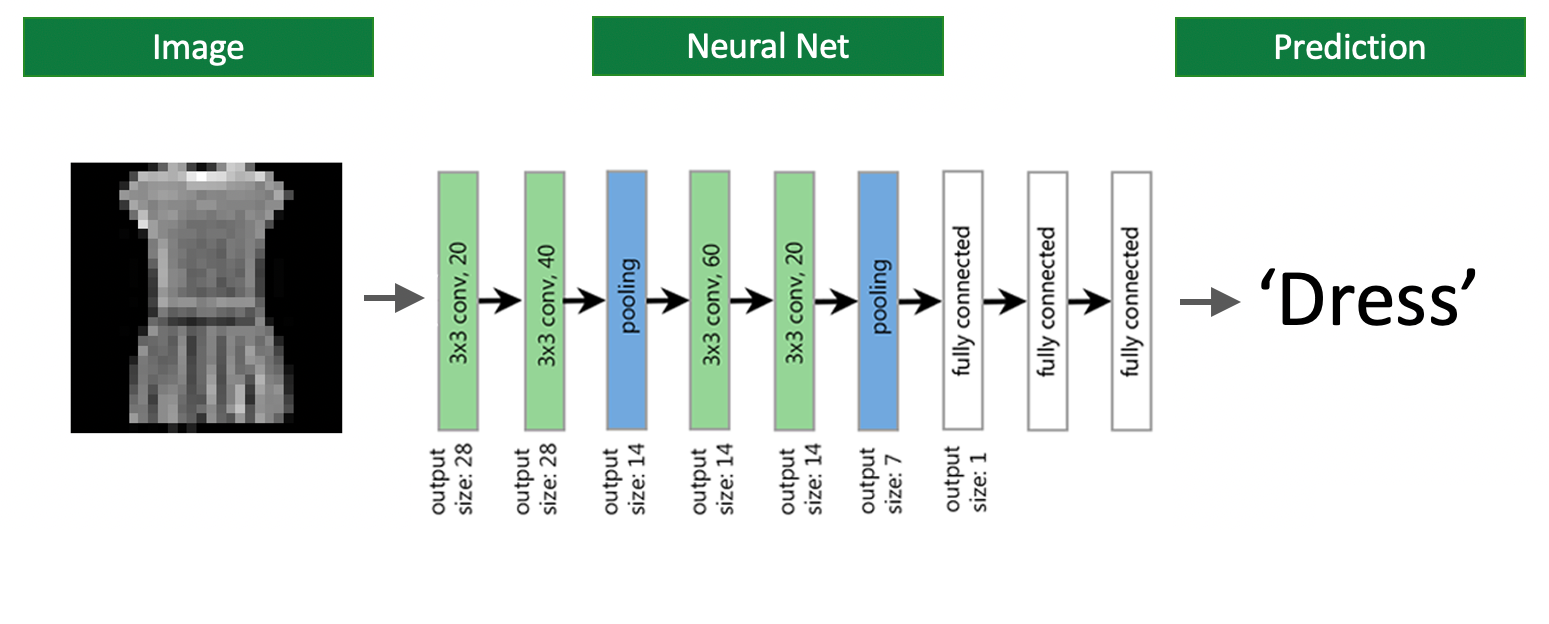

You can learn more about this dataset at:
* [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist)

## 1. Assignment objectives

After this assignment, you should be able to:

> 1. Learn how to use and implement the **VGG19** for image classification.
> 2. Understand the effect of increasing convolutional layers.
> 3. Understand why we add zero padding to input images.
> 4. Know how to **interpret the networks classification results** and **confusion matrix**.


## 2. Setup of the Jupyter Notebook Environment

At first, we need to import a couple of Python libraries that allow for data analysis and data visualization.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Import `Google's GDrive` connector and mount your `GDrive` directories:

In [ ]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Create a structure of `Colab` Notebook sub-directories inside of `GDrive` to to store the data and the trained neural network models:

In [3]:
# create Colab Notebooks directory
notebook_directory = '/content/drive/MyDrive/Colab Notebooks'
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

 # create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/Colab Notebooks/data_fmnist'
if not os.path.exists(data_directory): os.makedirs(data_directory)

 # create models sub-directory inside the Colab Notebooks directory
models_directory = '/content/drive/MyDrive/Colab Notebooks/models_fmnist'
if not os.path.exists(models_directory): os.makedirs(models_directory)

Set a random `seed` value to obtain reproducable results:

In [ ]:
# init deterministic seed

seed_value = # YOUR CODE HERE # INPUT YOUR STUDENT NUMBER HERE, omit the letters
assert type(seed_value) is int, "Exclude letters, leave only numbers"


np.random.seed(seed_value) # set numpy seed

Enable GPU computing by setting the device flag and init a CUDA and MPS seed. CUDA is used for Nvidia GPUs and MPS is used for Apple MacBooks with Apple Silicon or discreet AMD GPUs:

In [ ]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu').type

# init deterministic GPU and CPU seed
torch.manual_seed(seed_value) # set pytorch seed

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

Let's determine if we have access to a GPU provided by e.g. `Google's Colab` environment:

In [ ]:
!nvidia-smi

## 3. FashionMNIST database

Let's download, transform and inspect the training images of the dataset. Therefore, let's first define the directory in which we aim to store the training data:

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

# download the dataset
trainset = torchvision.datasets.FashionMNIST(root=data_directory, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_directory, train=False, download=True, transform=transform)

# define the labels of the images
classes = ['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# specify the batch size for training and test
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

In [ ]:
# determine the number of training data images
len(trainset)

In [ ]:
# determine the number of test data images
len(testset)

Great, let's now visually inspect our sample image:

In [11]:
# define a function for plot
def plot_images(images, n_rows=1):
    fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    for ax, img in zip(axs.flat, images):
        ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout(w_pad=0)

In [ ]:
images, labels = next(iter(trainloader))
plot_images(images[:8], n_rows=2)

## 4. Neural Network Implementation

**TASK A** – implement VGG network **(10 points)**
---
Now, you will implement the architecture of the **VGG19**. You aim to learn a model that is capable of classifying the 28x28 pixel FashionMNIST images according to the objects contained in each image.

The architecture:
- One convolutional layer with:
    - 3x3 kernel
    - 20 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- One convolutional layer with:
    - 3x3 kernel
    - 40 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- Max pooling layer with 2x2 kernel and stride 2.
- One convolutional layer with:
    - 3x3 kernel
    - 60 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- One convolutional layer with:
    - 3x3 kernel
    - 20 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- Max pooling layer with 2x2 kernel and stride 2.
- A block of three linear layers with ReLU nonlinearity with:
    - linear layers with 20x7x7 inputs and 100 outputs
    - ReLU nonlinearity
    - linear layers with 100 inputs and 50 outputs
    - ReLU nonlinearity
    - linear layers with 50 inputs and 10 outputs

Notes:
* Batch normalization is expected to be right after a convolutional layer, before nonlinearity.
* We recommend that you check the number of modules with trainable parameters in your network.

In [13]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # convolutional layers
        # YOUR CODE HERE


            # convolutional layer 1
            # YOUR CODE HERE

            # convolutional layer 2
            # YOUR CODE HERE


            # pooling layer 1
            # YOUR CODE HERE


            # convolutional layer 3
            # YOUR CODE HERE


            # convolutional layer 4
            # YOUR CODE HERE


            # pooling layer 2
            # YOUR CODE HERE


        # fully connected layers
        # YOUR CODE HERE

    def forward(self, x, verbose=False):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
          verbose: True if you want to print the shapes of the intermediate variables.

        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        x = self.convolutional_layer(x)
        x = x.view(-1, 20*7*7)
        x = self.linear_layer(x)
        return x

In [ ]:
def test_VGGNet_shapes():
    net = VGGNet()
    net.to(device)

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = next(iter(trainloader))
        images = images.to(device)
        print('Shape of the input tensor:', images.shape)

        y = net(images, verbose=True)
        assert y.shape == torch.Size([trainloader.batch_size, 10]), f"Bad y.shape: {y.shape}"

    print('Success, shapes are correct :)')

test_VGGNet_shapes()

In [17]:
# Initiate the network
net = # YOUR CODE HERE

In [18]:
# Send the network to to your compuational device
# YOUR CODE HERE


In [ ]:
# Check that that Google Colab GPU received the network (memory usage has changed)
!nvidia-smi

## 5. Neural Network Model Training

**TASK B** – train VGG network **(7 points)**
---


Your task is to implement the training loop. The recommended hyperparameters:
* Adam optimizer with learning rate 0.01.
* Cross-entropy loss. Note that we did not use softmax nonlinearity in the final layer of our network. Therefore, we need to use a loss function with log_softmax implemented, such as [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).
* Number of epochs: 10

We recommend you to use function `compute_accuracy()` defined below to track the accaracy during training. The test accuracy should be above 0.9.

**Note: function `compute_accuracy()` sets the network into the evaluation mode which changes the way the batch statistics are computed in batch normalization. You need to set the network into the training mode (by calling `net.train()`) when you want to perform training.**

In [ ]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
# define the optimization criterion / loss function
ce_loss = # YOUR CODE HERE

# define learning rate and optimization strategy
learning_rate = # YOUR CODE HERE
optimizer = # YOUR CODE HERE

# init collection of training epoch losses
train_losses = []

# set the model in training mode
# YOUR CODE HERE

# set the number of epochs
epochs = # YOUR CODE HERE

# Implement the training loop
for epoch in range(epochs):

    # init the time
    time0 = time.time()

    # init collection of mini-batch losses
    running_loss=[]

    # iterate over all-mini batches
    for batch_idx, data in enumerate(trainloader,0):

        # push mini-batch data to computation device
        # YOUR CODE HERE


        # run forward pass through the network
        # YOUR CODE HERE

        # reset graph gradients
        # YOUR CODE HERE

        # determine classification loss
        # YOUR CODE HERE

        # run backward pass
        # YOUR CODE HERE

        # update network paramaters
        # YOUR CODE HERE

        # collect mini-batch reconstruction loss
       # YOUR CODE HERE

    # determine mean min-batch loss of epoch
    train_loss = # YOUR CODE HERE
    train_losses.append(train_loss)

    # print epoch loss
    if epoch % 1 == 0:
        print(
            f"epoch:{epoch+1}",
            "\ttrain_loss:",
            round(train_loss, 3),
            "\taccuracy:",
            round(compute_accuracy(net, testloader),3),
            "\tUsed_time:",
                round((time.time()-time0)/60,3)
        )


#    if train_loss < 0.2:
#      break
# condition for early stop to reduce overfitting, you can try using it and compare the evaluation accuracy between different numbers of epochs

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_losses)+1)), train_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

## 6. Neural Network Model Evaluation

**Task C1** - evaluate the performance of the neural network **(3 points)**
--

In [24]:
# save the trained model
model_name = '2_vgg_net.pth'
torch.save(net.state_dict(), os.path.join(models_directory, model_name))

In [25]:
# initialize the model
model = # YOUR CODE HERE

In [ ]:
# load pre-trained models
model.load_state_dict(torch.load(os.path.join(models_directory, model_name), map_location=torch.device('cpu')))

In [ ]:
# set model in evaluation mode
# YOUR CODE HERE

In [28]:
# set (random) image id
image_id = # YOUR CODE HERE

# retrieve image exhibiting the image id
eval_image, eval_label = testset[image_id]

In [ ]:
# the true label of the image
classes[eval_label]

In [ ]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title
plt.title('Example: {}, Label: {}'.format(str(image_id), str(classes[eval_label])))

# un-normalize Fashion image sample
eval_image_plot = eval_image / 2.0 + 0.5

# plot Fashion-MNIST image sample
plt.imshow(trans(eval_image_plot))

In [ ]:
# predict the label of the random image
most_probable =  # YOUR CODE HERE
print('Most probable class: {}'.format(most_probable))
print('This class represents the following fashion article: {}'.format(classes[most_probable]))

In [32]:
# store the predicted classes on the test set
predictions = []
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

In [ ]:
# Compute the accuracy on the test set
accuracy = # YOUR CODE HERE
print(f'Accuracy of the VGGNet on the test images: {accuracy: .3f}')

In [ ]:
# determine classification matrix of the predicted and target classes
mat =  # YOUR CODE HERE

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=classes, yticklabels=classes)
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('FashionMnist classification matrix')

# set plot axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]')

## 7. Assignment Summary:

**Task C2** - discuss the implementation of the neural network **(5 points)**
--
Discuss the following:
- What are the effects of a deeper neural network?
- What are the effects of padding?
- Why do we use the max pooling layer?
- The rationale behind your choices of hyperparameters.
- A detailed analysis on the evaluation results.

(Your answer here)